In diesem Notebook wird der Datensatz base_fake_real.csv verwendet und untersucht wie man Fake-Reviews von Echten Reviews unterscheiden kann. Zuerst wird der Datensatz so vorbeietet um Features zu generieren


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib
from fastai.vision.all import *
from fastdownload import download_url

pd.set_option("display.max_rows", None)

### Datensatz für Feature Extraction zu feature_base.csv vorbereitet


In [ ]:
df = pd.read_csv("base_fake_real.csv")
print(f"Base Datensatz: {df.shape}")
# print(df.columns)

df.drop(
    [
        "index_fake",
        "org_text",
        "org_stars",
        "sent_score_0",
        "sent_v2",
        "sent_v3",
        "sent_v3.1",
        "prompt_v3",
        "website",
        "dalle_prompt",
        "website",
        "prompt_v2",
        "gpt3_v2",
        "gpt3_v3",
        "gpt3_v3.1",
        "prompt_v4",
        "org_reviewId",
        "sent_v4",
        "keywords",
        "keywords_only",
        "text_length",
        "reviewImageUrls/3",
        "reviewerPhotoUrl",
        "reviewerUrl",
        "reviewerId",
        "temporarilyClosed",
        "reviewsCount",
        "street",
        "state",
        "totalScore",
        "subTitle",
        "description",
        "price",
        "sentiment",
    ],
    axis=1,
    inplace=True,
)

df = df.reindex(
    columns=[
        "label",
        "reviewId",
        "placeId",
        "reviewUrl",
        "url",
        "title",
        "categoryName",
        "genre",
        "text",
        "stars",
        "publishedAtDate",
        "likesCount",
        "name",
        "isLocalGuide",
        "reviewerNumberOfReviews",
        "reviewImageUrls/0",
        "reviewImageUrls/1",
        "reviewImageUrls/2",
    ]
)

print(f"Reduzierter Datensatz als neue Basis für FE: {df.shape}")
print(df.columns)
print(df.dtypes)

df.to_csv("base_features.csv", index=False)
df.to_excel("base_features.xlsx", index=False)


## Tabular: Feature Generierung

1. aus publishedAt das bestmögliche rausholen

when_on_day_4hbin:
Midnight: 0-4 hours
Early morning: 4-8 hours
Morning: 8-12 hours
Early afternoon: 12-16 hours
Late afternoon: 16-20 hours
Evening: 20-24 hours -->


In [ ]:
df = pd.read_csv("base_features.csv")
print(df["publishedAtDate"][977])

df["publishedAtDate"] = pd.to_datetime(
    df["publishedAtDate"], format="%Y-%m-%dT%H:%M:%S"
)

df["year"] = df["publishedAtDate"].dt.year
df["month"] = df["publishedAtDate"].dt.month
df["dayofweek"] = df["publishedAtDate"].dt.dayofweek
df["elapsed_days"] = (datetime.today() - df["publishedAtDate"]).dt.days
df["when_on_day_4hbin"] = pd.cut(
    df["publishedAtDate"].dt.hour,
    bins=[-1, 4, 8, 12, 16, 20, 24],
    labels=[0, 1, 2, 3, 4, 5],
)

df["when_on_day_hour"] = df["publishedAtDate"].dt.hour

print(df["when_on_day_4hbin"].isna().sum())
print(df.loc[df["when_on_day_4hbin"].isna(), "publishedAtDate"])

print(
    df[
        [
            "publishedAtDate",
            "year",
            "month",
            "dayofweek",
            "elapsed_days",
            "when_on_day_4hbin",
            "when_on_day_hour",
        ]
    ].head(10)
)

df.to_csv("feature_enriched_tab.csv", index=False)
df.to_excel("feature_enriched_tab.xlsx", index=False)


### Nur für mich ein Test, wie ich ein Basic Decsion Tree anwende und für grobes Gefühl, wie aussagekräftig das alles ist.

Decision tree accuracy: 0.69


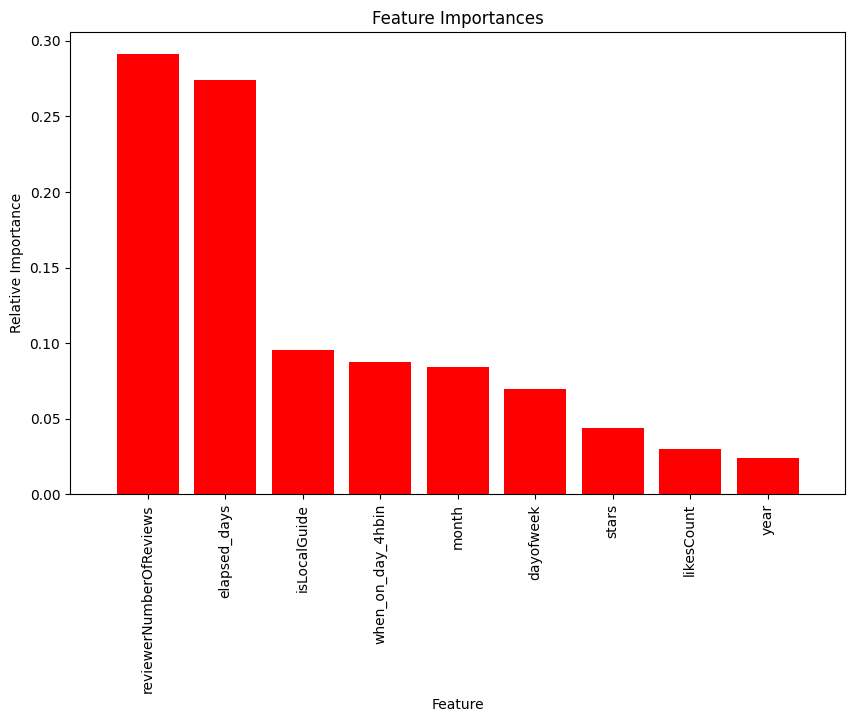

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv("feature_enriched_tab.csv")

df = df[
    [
        "stars",
        "year",
        "month",
        "likesCount",
        "reviewerNumberOfReviews",
        "isLocalGuide",
        "dayofweek",
        "elapsed_days",
        "when_on_day_4hbin",
        "label",
    ]
]
df["label"] = (df["label"] == "real").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("label", axis=1), df["label"], test_size=0.2, random_state=11
)

clf = DecisionTreeClassifier(random_state=1)

clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)

print(f"Decision tree accuracy: {score:.2f}")

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)

plt.ylabel("Relative Importance")
plt.xlabel("Feature")
plt.xlim([-1, X_train.shape[1]])
plt.show()


## Bild: Feature Generierung

### Feature Extrahieren über Pretrained ResNet-18 Architektur und in Dataframe abspeichern.


In [12]:
df = pd.read_csv("feature_enriched_tab.csv")
image_urls = df["reviewImageUrls/0"]

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)
# Remove the last fully connected layer
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features for a single image
def extract_image_features(image_url):
    # Load image and preprocess
    img = Image.open(requests.get(image_url, stream=True).raw)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0)

    # Extract features
    with torch.no_grad():
        features = resnet(img)
        features = features.squeeze().numpy()

    return features

c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import requests
import os
counter = 0
feature_vectors = []
for image_url in image_urls:
    try:
        counter += 1
        print(f'{counter}:\tExtracting features from {image_url}')
        features = extract_image_features(image_url)
    except:
        print(f'Error extracting features from {image_url}. Replaces with NaN.')
        features = np.full((512,), np.nan)
    feature_vectors.append(features)

feature_df = pd.DataFrame(feature_vectors, columns=[f'feature_{i}' for i in range(512)])


In [ ]:
new_df = pd.concat([df, feature_df], axis=1)
print("added features to the original dataset.")

print(new_df.iloc[0])
# new_df.to_csv('feature_enriched_tab_img.csv', index=False)
# new_df.to_excel('feature_enriched_tab_img.xlsx', index=False)

# visualize as PCA

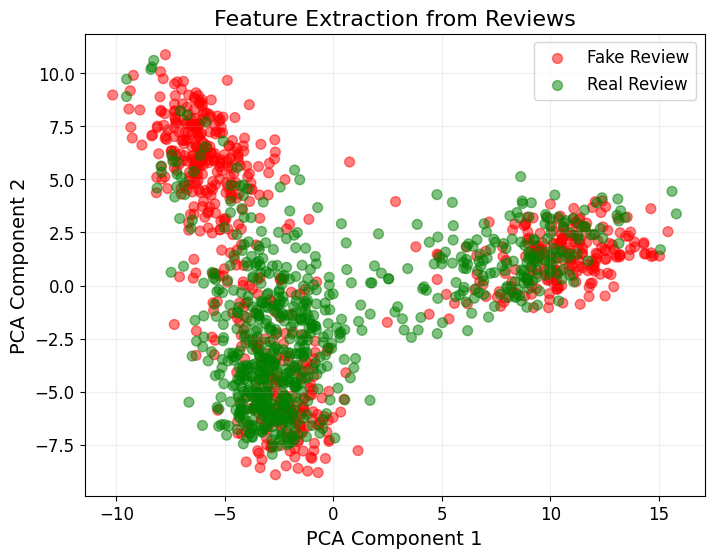

In [109]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your dataframe
df = pd.read_csv('feature_enriched_tab_img.csv')

# drop row with index 764
df = df.drop(764)

# Select feature columns and label
features = df.iloc[:, 0:1].join(df.iloc[:, 24:])

# drop all rows with NaN values in feature columns
features = features.dropna(subset=features.columns[1:], how='all')

# Define color map
color_map = {'fake': 'red', 'real': 'green'}

# Map labels to colors
colors = features['label'].apply(lambda x: color_map[x])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features.iloc[:, 1:])

# Visualize the reduced features, colored by label
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=colors, alpha=0.5, s=50)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.title('Feature Extraction from Reviews', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.grid(alpha=0.2)
plt.legend(handles=[plt.scatter([], [], c='red', label='Fake Image', alpha=0.5, s=50),
                     plt.scatter([], [], c='green', label='Real Image', alpha=0.5, s=50)],
           loc='upper right', fontsize=12)
plt.savefig('feature_extraction.svg', format='svg')
plt.show()


## Visualisierung der Features bzw. der Feature Map 
Visualierung der Durch das CNN gejagten Bilder. Am Ende kommen die Features raus...

In [68]:
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Remove the last fully connected layer
modules = list(model.children())[:-1]
model = torch.nn.Sequential(*modules)

# Set the device to use for computation (e.g. GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the image transformations to be applied
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Load your dataset of images and preprocess them as needed
# image_paths = ['path/to/image1.jpg', 'path/to/image2.jpg', ...]
#
image_paths = ['02_Images/fake_image_url_2/703_ChZDSUhNMG9nS0VJQ0FnSURVN2VTYVZnEAEF_fake_reviewImageUrls_2.png', '02_Images/fake_image_url_2/698_ChZDSUhNMG9nS0VJQ0FnSUNtcGNud1NBEAEF_fake_reviewImageUrls_2.png']
images = []
for path in image_paths:
    img = Image.open(path)
    img = transform(img)
    images.append(img)
images = torch.stack(images).to(device)

# Pass each image through the model to extract the 512-dimensional feature vector
features = model(images)
features = features.squeeze().cpu().detach().numpy()

# Store the feature vectors in a dataframe with one column per feature
df = pd.DataFrame(features)

# Use t-SNE to reduce the dimensionality of the feature vectors to two dimensions

print(df)


c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


        0         1         2         3         4         5         6    \
0  1.327207  0.135304  0.505072  1.145497  0.252702  0.120766  0.562021   
1  0.442227  1.724968  1.325351  0.953620  1.454216  1.466827  1.343560   

        7         8         9    ...       502       503       504       505  \
0  0.878252  0.502374  0.569093  ...  1.507536  0.608942  0.233182  0.843172   
1  1.418468  1.472291  1.326761  ...  0.386968  1.218183  1.478787  0.914851   

        506       507       508       509       510       511  
0  1.529930  1.075623  0.694748  1.615343  0.715970  1.505832  
1  0.598533  0.979692  1.207988  0.230641  1.290882  0.442949  

[2 rows x 512 columns]


In [62]:
def visualize_layer_features(model, layer_num, input_img):
    # Get the layer to visualize
    layer_num_map = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1),
                     4: (2, 0), 5: (2, 1), 6: (3, 0), 7: (3, 1)}
    print(f"Layer_num{layer_num_map[layer_num]}")
    stage_num, block_num = layer_num_map[layer_num]
    layer = getattr(model, f'layer{stage_num+1}')[block_num]

    # Create a forward hook to get the layer's output
    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    layer.register_forward_hook(hook)

    # Forward pass the input image through the model
    _ = model(input_img)

    # Get the output tensor and convert to numpy array
    feature_maps = outputs[0].detach().numpy()

    # Plot the feature maps as a grid
    fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
    axs = axs.flatten()
    for i in range(64):
        axs[i].imshow(feature_maps[0, i, :, :], cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()

    # Save the figure
    fig.savefig(f"layer{layer_num}.png")
    plt.close(fig)


for i in range(14):
    visualize_layer_features(resnet, i, input_img)


Layer_num(0, 0)
Layer_num(0, 1)
Layer_num(1, 0)
Layer_num(1, 1)
Layer_num(2, 0)
Layer_num(2, 1)
Layer_num(3, 0)
Layer_num(3, 1)


KeyError: 8

In [28]:
# Define a function to visualize the feature maps of a layer
def visualize_layer_features(model, layer_num, input_img):
    # Get the layer to visualize
    layer = model.layer1[layer_num] if layer_num < 4 else model.layer2[layer_num - 4] \
            if layer_num < 8 else model.layer3[layer_num - 8] \
            if layer_num < 12 else model.layer4[layer_num - 12]

    # Create a forward hook to get the layer's output
    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    layer.register_forward_hook(hook)

    # Forward pass the input image through the model
    _ = model(input_img)

    # Get the output tensor and convert to numpy array
    feature_maps = outputs[0].detach().numpy()

    # Plot the feature maps as a grid
    fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
    axs = axs.flatten()
    for i in range(64):
        axs[i].imshow(feature_maps[0, i, :, :], cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()

    # Save the figure
    fig.savefig(f"layer{layer_num}.png")
    plt.close(fig)


# Load an example image
img_path = '02_Images/fake_image_url_2/43_ChZDSUhNMG9nS0VJQ0FnSURRdTh6UEJnEAEF_fake_reviewImageUrls_2.png'
img = Image.open(img_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_img = transform(img)
input_img = input_img.unsqueeze(0)

# Create a directory to save the feature maps
if not os.path.exists('feature_maps'):
    os.makedirs('feature_maps')

# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

# Visualize the feature maps for each layer
for i in range(18):
    visualize_layer_features(resnet, i, input_img)


IndexError: index 2 is out of range

In [42]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

# Define a function to visualize the feature maps of a layer
def visualize_layer_features(layer_num, input_img):
    # Get the layer to visualize
    layer = resnet.layer1[layer_num]

    # Create a forward hook to get the layer's output
    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    layer.register_forward_hook(hook)

    # Forward pass the input image through the model
    _ = resnet(input_img)

    # Get the output tensor and convert to numpy array
    feature_maps = outputs[0].detach().numpy()

    # Plot the feature maps as a grid
    fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
    axs = axs.flatten()
    for i in range(64):
        axs[i].imshow(feature_maps[0, i, :, :], cmap='gray')
        axs[i].axis('off')
    plt.tight_layout()

    # Save the figure
    fig.savefig(f"layerWW{layer_num}.png")
    plt.close(fig)


# Load an example image
img_path = '02_Images/fake_image_url_2/43_ChZDSUhNMG9nS0VJQ0FnSURRdTh6UEJnEAEF_fake_reviewImageUrls_2.png'
img = Image.open(img_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_img = transform(img)
input_img = input_img.unsqueeze(0)

# Create a directory to save the feature maps
if not os.path.exists('feature_maps'):
    os.makedirs('feature_maps')

# Visualize the feature maps for each layer
for i in range(4):
    visualize_layer_features(i, input_img)


IndexError: index 2 is out of range

In [43]:
import os

# Define a function to perform activation maximization on a given feature and save the result to disk
def visualize_and_save_feature(model, feature_index, save_dir, num_iterations=500):
    # Set the model to evaluation mode
    model.eval()

    # Define a random input image
    input_image = torch.randn(1, 3, 224, 224, requires_grad=True)

    # Define a transformation to preprocess the input image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Define an optimizer to update the input image
    optimizer = torch.optim.Adam([input_image], lr=0.1)

    # Perform activation maximization for a certain number of iterations
    for i in range(num_iterations):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        output = model(input_image)

        # Compute the mean activation of the specified feature
        feature_activation = output[0, feature_index].mean()

        # Compute the gradient of the feature activation with respect to the input image
        feature_activation.backward()

        # Update the input image
        optimizer.step()

    # Convert the input image to a numpy array and unnormalize it
    input_image = input_image.detach().numpy()[0]
    input_image = (input_image * np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))) + np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    input_image = np.clip(input_image, 0, 1)

    # Save the input image to disk
    filename = f'feature_{feature_index}.png'
    save_path = os.path.join(save_dir, filename)
    plt.imsave(save_path, np.transpose(input_image, (1, 2, 0)))

# Visualize and save the first 3 features
save_dir = 'feature_visualizations'
os.makedirs(save_dir, exist_ok=True)

for i in range(511, 512):
    visualize_and_save_feature(model, i+1, save_dir)

NameError: name 'model' is not defined

# Filter

Using cache found in C:\Users\michi/.cache\torch\hub\pytorch_vision_main
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsh

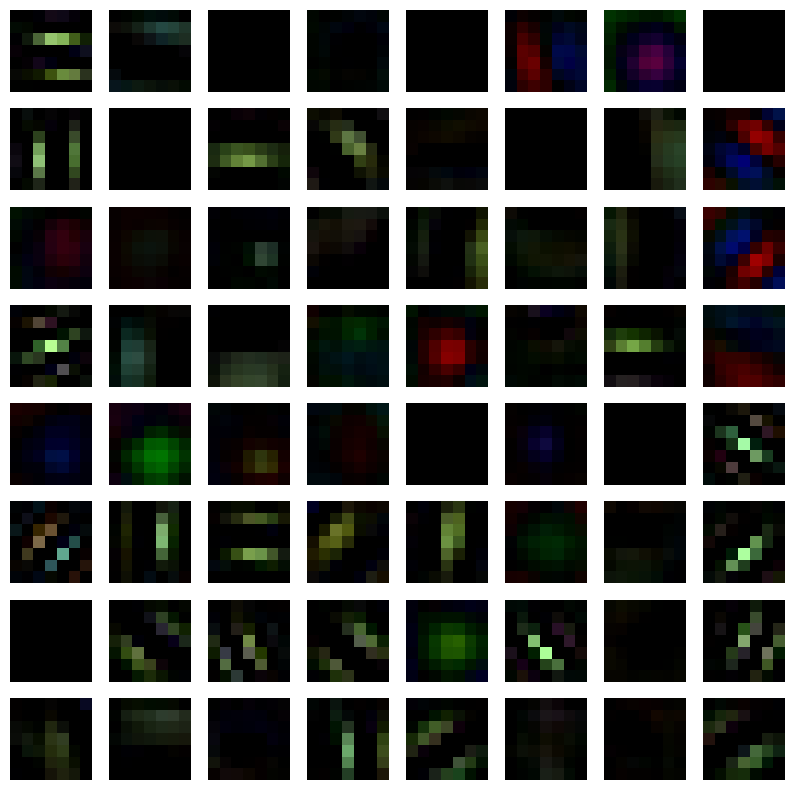

In [44]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Load pre-trained ResNet-18 model
resnet = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)

# Get the first convolutional layer
conv1 = resnet.conv1

# Generate feature visualizations
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for i in range(8):
    for j in range(8):
        filter_idx = i * 8 + j
        filter_img = conv1.weight.data[filter_idx].cpu().numpy().transpose(1, 2, 0)
        axs[i, j].imshow(filter_img)
        axs[i, j].axis('off')

plt.show()

## Text: Feature Generierung

1. Feature extrahieren über PNLP Paket, wie z.B: lenth, adverb, Großklein, Rechtschriebung, Smiley-Nutzung


In [55]:
import emoji
import string
import nltk

In [57]:
df = pd.read_csv("feature_enriched_tab_img.csv")


df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_punctuation'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

def entire_capitalized_percentage(text):
    words = text.split()
    num_words = len(words)
    words = [word for word in words if word.lower() != "i"]
    num_capitalized = sum([1 for word in words if word.isupper()])
    return num_capitalized / num_words * 100

df['text_entired_capitalized_quota'] = df['text'].apply(entire_capitalized_percentage)

def count_emojis(text):
    emoji_count =  0
    for character in text:
        if character in emoji.EMOJI_DATA:
            emoji_count += 1
    return emoji_count
df['text_emoji_count'] = df['text'].apply(count_emojis)


def avg_word_length(text):
    words = text.split()
    num_words = len(words)
    if num_words == 0:
        return 0
    else:
        total_length = sum([len(word) for word in words])
        return total_length / num_words
df['text_avg_word_length'] = df['text'].apply(avg_word_length)

def avg_sentence_length(text):
    sentences = nltk.sent_tokenize(text)
    num_sentences = len(sentences)
    if num_sentences == 0:
        return 0
    else:
        total_length = sum([len(sentence.split()) for sentence in sentences])
        return total_length / num_sentences
df['text_avg_sentence_length'] = df['text'].apply(avg_sentence_length)


print(df[['text', 'text_length', 'text_punctuation', 'text_entired_capitalized_quota', 'text_emoji_count', 'text_avg_word_length', 'text_avg_sentence_length']].head(10))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
0                                                                                                                                                                                                                                                                                                                                                     Staff has been great every time my kids rent a place

## Exkurs: Eigenen Img-Klassifikator trainiert und ausgwertet


Bilder für Training vorberieten und


In [ ]:
df = pd.read_csv("train_weitere_forschung_ohne_base.csv")

df = df.sample(n=500, random_state=9)
# df = df.sample(n=1000, random_state=42)
df = df.sort_index()

for index, row in df.iterrows():
    if index < 0:
        print(f"Index {index} schon heruntergeladen, skipped ..")
        continue
    for i in range(2):
        if not pd.isna(row[f"reviewImageUrls/{i}"]):
            print(f"Downloading image for {index}...")
            url = row[f"reviewImageUrls/{i}"]
            filename = f"{url.split('/')[-1]}.png"
            path = os.path.join("02_Images", "train", "real", filename)
            if not os.path.exists(path):
                try:
                    urllib.request.urlretrieve(url, path)
                except:
                    print(f"Error with {url}")

print("Done with downloading real images for training set.")

Start Umsetzung mit FASTAI visual Learning als Classifizierung Problem (AUF COLAB!)


In [ ]:
df = pd.read_csv("base_keywords_sentiment_reduced.csv")
print(df.shape)

df_all = pd.read_csv("01_Data/raw_data/dataset_weitere_forschung.csv")
print(df_all.shape)

df_all = df_all[
    [
        "text",
        "reviewId",
        "url",
        "placeId",
        "categoryName",
        "stars",
        "title",
        "reviewImageUrls/0",
        "reviewImageUrls/1",
        "reviewImageUrls/2",
        "reviewImageUrls/3",
        "reviewImageUrls/4",
        "reviewImageUrls/5",
        "genre",
    ]
]
df_all = df_all[df_all["reviewImageUrls/0"].notna()]
print(df_all.shape)
df_all = df_all[~df_all["reviewId"].isin(df["reviewId"])]
print(df_all.shape)
print(df_all.columns)

image_urls_cols = [
    "reviewImageUrls/0",
    "reviewImageUrls/1",
    "reviewImageUrls/2",
    "reviewImageUrls/3",
    "reviewImageUrls/4",
    "reviewImageUrls/5",
]
for col in image_urls_cols:
    print(f"Processing col {col}")
    df_all[col] = df_all[col].str.replace("=w150-h150-k-no-p", "=w256-h256-p-k-no")

print(df_all.shape)

# df_all.to_csv('train_weitere_forschung_ohne_base.csv', index=False)
# df_all.to_excel('train_weitere_forschung_ohne_base.xlsx', index=False)


Hier nur die Auswertung. Training in colab.ipynb Notebook.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib import colors

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "Book Antiqua"

df = pd.read_csv("base_fake_real_imgcls_pred.csv")

y_true = df["label"]
y_pred = df["prediction_0"]

accuracy = accuracy_score(y_true, y_pred)
recall = classification_report(y_true, y_pred, output_dict=True)["weighted avg"][
    "recall"
]
precision = classification_report(y_true, y_pred, output_dict=True)["weighted avg"][
    "precision"
]
f1_score = classification_report(y_true, y_pred, output_dict=True)["weighted avg"][
    "f1-score"
]

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")

cmap = colors.ListedColormap(["#FFE5E4", "#D7F3D9"])

labels = y_true.unique()
fig, ax = plt.subplots(figsize=(5, 2.5))

cm = confusion_matrix(y_true, y_pred, labels=labels)


# Plot confusion matrix with custom colors
sns.heatmap(
    cm,
    annot=True,
    cmap=cmap,
    fmt="g",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
)
plt.xlabel("Vorhersage")
plt.ylabel("Tatsächlich")

plt.savefig("confusion_matrix_green_red.svg", format="svg", bbox_inches="tight")
